## TOPIC Identification of Mathematical word problems
Using GLoVe - Word Embeddings 

### Load the DeepMind AQuA Data Set 

In [2]:
import pandas as pd
import numpy as np
import json 

In [3]:
qb =  pd.read_json('AQuA-master/dev.json',lines=True)
qb.columns

Index(['correct', 'options', 'question', 'rationale'], dtype='object')

In [4]:
qb.head()

,correct,options,question,rationale
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ..."
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's..."


### Remove Named Entities 

In [5]:
import nltk
import string
def untokenize(tokens):
    return("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip())


def extract_nonentities(tree):
    tokens = [leaf[0] for leaf in tree if type(leaf) != nltk.Tree]
    return(untokenize(tokens))

def ne_removal(text_list):
    token_list = [nltk.word_tokenize(text) for text in text_list]
    tagged = nltk.pos_tag_sents(token_list)
    chunked = nltk.ne_chunk_sents(tagged)
    non_entities = []
    for tree in chunked:
        non_entities.append(extract_nonentities(tree))
    return(non_entities)

In [6]:
# removal of named entities
qb['qn'] = ne_removal(qb['question'])


### Pre process text  - convert to lower case , remove numeric , special characters

In [7]:
import re
qb.qn = qb.qn.apply(lambda x: x.lower())
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\%', 'percent', x))
qb['qn'] = qb['qn'].apply(lambda x:re.sub("[^a-zA-Z]",' ',x))


In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Split the question into word list for vectorization

In [9]:
qb['qn']=qb['qn'].apply(lambda x: x.split())
qb.head()

,correct,options,question,rationale,qn
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...,"[three, birds, are, flying, at, a, fast, rate,..."
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...,"[a, ship, is, leaving, a, port, it, takes, sec..."
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ...","[a, rectangular, piece, of, cloth, feet, wide,..."
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...,"[in, the, xy, coordinate, plane, which, of, th..."
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's...","[a, travel, company, wants, to, charter, a, pl..."


### Tokenize all the word vectors

In [10]:
AllText = qb['qn'].values

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(AllText)
vocab_size = len(t.word_index) + 1
print(vocab_size)


Using TensorFlow backend.


1573


### Load the GloVe Word embeddings 

In [11]:
import io
embeddings_index = dict()
with io.open("./glove.6B/glove.6B.300d.txt", "r", encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
#f.close()
print('Loaded %s word vectors from GloVe.' % len(embeddings_index))
      

Loaded 400000 word vectors from GloVe.


### Map Words in the Question dataset to the GloVe Embeddings 

In [12]:
# create a weight matrix for words in training docs
vocab = []
embedding_matrix = np.zeros((vocab_size, 300))
err_count = 0
for word, i in t.word_index.items():
    vocab.append(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else :
        print("Can't find Glove word vector for :{}".format(word))
        err_count +=1
vocab.append("-null")

Can't find Glove word vector for :whatpercent
Can't find Glove word vector for :yuvaraj
Can't find Glove word vector for :dbef
Can't find Glove word vector for :playerwho
Can't find Glove word vector for :thepercent
Can't find Glove word vector for :huhulians
Can't find Glove word vector for :koolaid
Can't find Glove word vector for :irder
Can't find Glove word vector for :prosthodontist


In [13]:
print(embedding_matrix.shape)

(1573, 300)


### Dimensionality Reduction using TSNE 

In [14]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
embedding_matrix_2d = tsne.fit_transform(embedding_matrix)

In [15]:
d = {"word":vocab,"x":embedding_matrix_2d[:,0],"y":embedding_matrix_2d[:,1]}
print(len(vocab))
pts=pd.DataFrame(d)
pts.head(10)

1573


,word,x,y
0,bad,19.759895,-20.468645
1,odd,1.633576,9.820148
2,opening,2.220507,10.114603
3,demand,4.625420,12.980789
4,carefully,-6.019231,4.154238
5,every,-1.552037,6.126178
6,frames,0.951316,14.498993
7,account,-11.132826,-8.034027
8,stick,-11.316639,-1.656354
9,was,13.063579,-0.149262


### Lets look the scatter plot of word vectors in the question set 

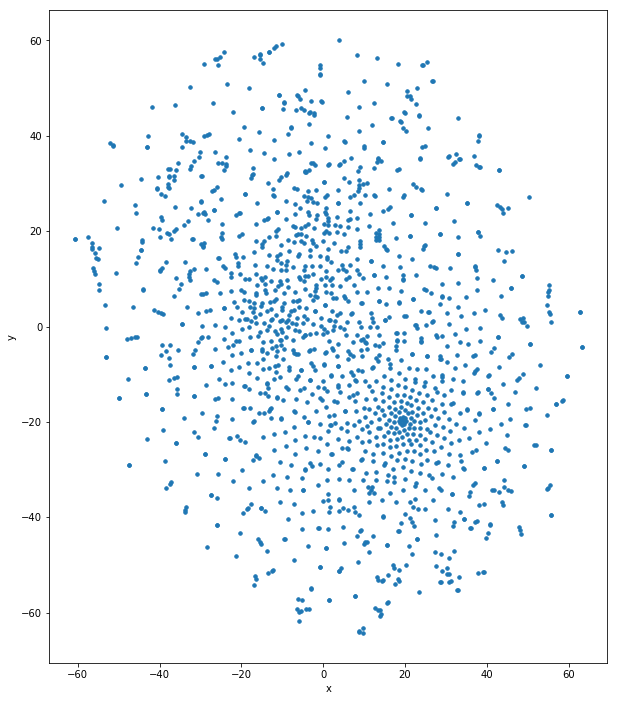

In [16]:
import seaborn as sns
%matplotlib inline
pts.plot.scatter("x", "y", s=12, figsize=(10, 12));

### Function to calculate the average vector for the sentence 

In [17]:
import numpy as np
from scipy import spatial


def avg_feature_vector(wordlist,  nfeatures):
    feature_vec = np.zeros((nfeatures, ), dtype='float32')
    nwords = 0

    for word in wordlist:

        if word in vocab : # word is glove-vocab
            nwords += 1
            if (embeddings_index.get(word)) is not None:
                feature_vec = np.add(feature_vec, embeddings_index.get(word))
    if (nwords > 0):
        feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

### For all the questions in the dataset , calculate the average feature vector 
- Reduce the dimension of the vector using TSNE

In [18]:
afv = []
for i in range(len(qb)) :
    fv = avg_feature_vector(qb['qn'][i], nfeatures=300)
    afv.append(fv)
afv_2d = tsne.fit_transform(afv)

### Cluster using the Average feature vector and cosine_distance as the 

In [20]:
from nltk.cluster import KMeansClusterer,euclidean_distance
import nltk

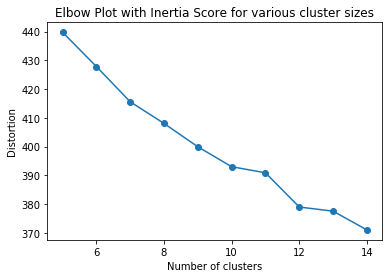

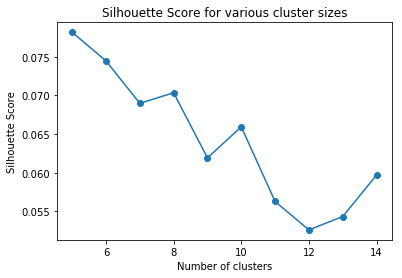

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

sil_scores = []
distortions = []
for i in range (5,15):
    km = KMeans(n_clusters=i,random_state=10,verbose=0)
    Y = km.fit_predict(afv)
 
    distortions.append(km.inertia_)
    if (i>=2):
        sc = (metrics.silhouette_score(afv, Y))
        sil_scores.append(sc)

plt.plot(range(5,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Plot with Inertia Score for various cluster sizes")
plt.show()


plt.plot(range(5,15), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score for various cluster sizes")
plt.show()

### Clustering using K-means

In [21]:
kclusterer = KMeansClusterer(12, distance=nltk.cluster.util.cosine_distance, repeats=40)
assigned_clusters = kclusterer.cluster(afv, assign_clusters=True)
qb['clusters'] = assigned_clusters

#kclusterer = KMeansClusterer(10, distance=nltk.cluster.util.cosine_distance, repeats=40)
#assigned_clusters = kclusterer.cluster(afv, assign_clusters=True)
#qb['clusters'] = assigned_clusters
#qb.to_csv("dev300.csv")

### Cluster Analysis

In [23]:
qset = { 'question': qb.question, 'cluster': assigned_clusters }
frame = pd.DataFrame(qset, columns = ['question','cluster'])

In [24]:
frame.head()

,question,cluster
0,Three birds are flying at a fast rate of 900 k...,4
1,A ship is leaving a port. It takes 240 seconds...,8
2,A rectangular piece of cloth 2 feet wide was c...,11
3,"In the xy-coordinate plane, which of the follo...",9
4,A travel company wants to charter a plane to t...,6


In [25]:
frame['cluster'].value_counts()

1     51
7     38
6     36
2     27
11    18
8     18
5     16
9     15
3     14
4      9
10     6
0      6
Name: cluster, dtype: int64

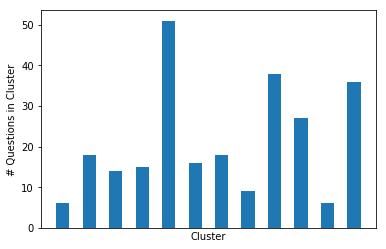

In [26]:
bar_width = 0.5 
plt.bar(frame['cluster'].unique(),frame['cluster'].value_counts(),width=bar_width)

plt.xticks([])
plt.xlabel('Cluster')
plt.ylabel('# Questions in Cluster')
plt.show()

### Cluster Analysis - Lets look at the questions in each cluster

In [27]:
grouped = frame['question'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
for key, item in grouped:
    print('-'*80)
    print("Questions in Cluster ",key)
    print('-'*80)
    x = grouped.get_group(key)
    cnt=0
    for i in x:
        print("[",cnt,"]",i)
        cnt=cnt+1;

--------------------------------------------------------------------------------
Questions in Cluster  0
--------------------------------------------------------------------------------
[ 0 ] The H.C.F and L.C.M. of two numbers are 50 and 100 respectively. If the first number is divided by 2, the quotient is 50, the second number is:
[ 1 ] The ratio of A’s and B’s salary is 9 : 4. If A’s salary is increased by 15%, then his total salary becomes 5175. What is the salary of B?
[ 2 ] If 2s > 8 and 4t < 12, which of the following could be the value of s-t?
I. -1
II. 0
III. 1
[ 3 ] Gina and Tina's average grade is 23 points higher than Tina's grade. What is the difference between their grades?
[ 4 ] Q is 30% of N. N is 170% of Y. What percentage of Y is Q?
[ 5 ] G and H are each equal to 20% of Z. If G, H, and F are equal to 100% of Z together, what percentage of Z is F?
--------------------------------------------------------------------------------
Questions in Cluster  1
----------------

In [28]:

qb["x"] = afv_2d[:,0]
qb["y"] = afv_2d[:,1]

qb.head(10)

,correct,options,question,rationale,qn,clusters,x,y
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...,"[three, birds, are, flying, at, a, fast, rate,...",4,-7.064785,8.952808
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...,"[a, ship, is, leaving, a, port, it, takes, sec...",8,-3.862454,6.397908
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ...","[a, rectangular, piece, of, cloth, feet, wide,...",11,-0.652996,13.357693
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...,"[in, the, xy, coordinate, plane, which, of, th...",9,1.924755,9.248408
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's...","[a, travel, company, wants, to, charter, a, pl...",6,0.150117,-3.169145
5,B,"[A)$895, B)$905, C)$910, D)$915, E)$945]","Kirk sells cars. On two sales, Kirk has receiv...",Let X be the third value.\n850 + 705 + X = 820...,"[sells, cars, on, two, sales, has, received, c...",6,1.765073,-3.769265
6,E,"[A)$203, B)$202, C)$209, D)$205, E)$204]",A group of 5 friends were to contribute equall...,"At the non-discounted price, each friend would...","[a, group, of, friends, were, to, contribute, ...",1,0.444863,-6.505519
7,B,"[A)5.5, B)6, C)7, D)8, E)8.25]","Let A, B and C denote the vertices of a triang...","First, note that 4AFD and 4AFE have the same a...","[let, a, b, and, c, denote, the, vertices, of,...",8,1.165585,9.291676
8,D,"[A)300, B)420, C)912, D)1340, E)1500]",ABC company pays an average of $120 per vehicl...,This means it could go out sometimes and it co...,"[company, pays, an, average, of, per, vehicle,...",4,7.043878,-4.953119
9,D,"[A)30 litres, B)27 litres, C)25 litres, D)22.5...",Solution A has 5% salt concentration and remai...,Before Evaporation:\nSalt : 5% of 50 litre = 2...,"[solution, a, has, percent, salt, concentratio...",5,-8.842921,-7.587666


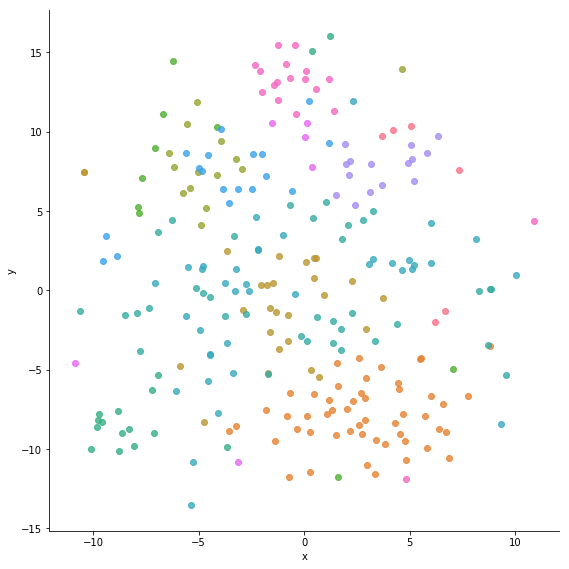

In [29]:
import seaborn as sns
%matplotlib inline

sns.lmplot( x="x", y="y", data=qb, fit_reg=False, hue='clusters', legend=False,size=8, aspect=1)

